# Library

In [1]:
# Importing the common libraries
import pandas as pd
import numpy as np

# importing the libraries for data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

# Importing the libraries for the model
import torch
from pytorch_tabnet.tab_model import TabNetClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE, ADASYN

# Importing the libraries for the evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score

# Importing additional libraries
import os
import wget
from pathlib import Path
import shutil
import gzip
import joblib


# Dataset

In [2]:
# Download titanic dataset
url = 'https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv'

# Define the file paths
data_path = Path('data')
data_file = data_path / 'titanic.csv'

# Store the data in the data folder
if not os.path.exists(data_path):
    os.makedirs(data_path)

# Download the data
if not os.path.exists(data_file):
    wget.download(url, data_file.as_posix())

# Load the data
data = pd.read_csv(data_file)

# Display the first 5 rows of the data
print(data.head())

   Survived  Pclass                                               Name  \
0         0       3                             Mr. Owen Harris Braund   
1         1       1  Mrs. John Bradley (Florence Briggs Thayer) Cum...   
2         1       3                              Miss. Laina Heikkinen   
3         1       1        Mrs. Jacques Heath (Lily May Peel) Futrelle   
4         0       3                            Mr. William Henry Allen   

      Sex   Age  Siblings/Spouses Aboard  Parents/Children Aboard     Fare  
0    male  22.0                        1                        0   7.2500  
1  female  38.0                        1                        0  71.2833  
2  female  26.0                        0                        0   7.9250  
3  female  35.0                        1                        0  53.1000  
4    male  35.0                        0                        0   8.0500  


In [3]:
# Check the data types of the columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Survived                 887 non-null    int64  
 1   Pclass                   887 non-null    int64  
 2   Name                     887 non-null    object 
 3   Sex                      887 non-null    object 
 4   Age                      887 non-null    float64
 5   Siblings/Spouses Aboard  887 non-null    int64  
 6   Parents/Children Aboard  887 non-null    int64  
 7   Fare                     887 non-null    float64
dtypes: float64(2), int64(4), object(2)
memory usage: 55.6+ KB


In [4]:
# Drop the columns that are not required
data.drop(['Name'], axis=1, inplace=True)

# Check the missing values in the data
print(data.isnull().sum())

Survived                   0
Pclass                     0
Sex                        0
Age                        0
Siblings/Spouses Aboard    0
Parents/Children Aboard    0
Fare                       0
dtype: int64


In [5]:
# Check survived column
print(data['Survived'].value_counts())

Survived
0    545
1    342
Name: count, dtype: int64


In [6]:
# Define the target and features
target = 'Survived'
features = data.columns.drop(target)

# Splitting Dataset

In [7]:
# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

In [8]:
# Check the shape of the train and test data
print(X_train.shape, X_test.shape)

(709, 6) (178, 6)


In [9]:
# Check the class distribution in the target
print(y_train.value_counts())

Survived
0    434
1    275
Name: count, dtype: int64


In [10]:
# Check unique values in Pclass
print(X_train['Pclass'].value_counts())

Pclass
3    394
1    170
2    145
Name: count, dtype: int64


In [11]:
# Define categorical columns
categorical_columns = ['Sex', 'Pclass']  # Include both 'Sex' and 'Pclass'

# Preprocessing Data

## Label Encoder

In [12]:
# Label encoder for the categorical columns using LabelEncoder

# Initialize the label encoder
label_encoders = {}
for cat_col in X_train.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_train[cat_col] = le.fit_transform(X_train[cat_col])
    X_test[cat_col] = le.transform(X_test[cat_col])
    label_encoders[cat_col] = le

In [13]:
# Check the first 5 rows of the data
X_train.head()

,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
730,2,1,23.0,0,0,13.000
390,3,1,28.0,2,0,7.925
118,3,0,2.0,4,2,31.275
440,2,0,28.0,0,0,13.000
309,1,0,18.0,2,2,262.375


In [14]:
# check label encoders
print(label_encoders)

{'Sex': LabelEncoder()}


In [15]:
# Save the label encoders using joblib
joblib.dump(label_encoders, 'Model/label_encoders.pkl')

['Model/label_encoders.pkl']

## Standar scaler

In [16]:
# Standardize the data without Pclass and Sex columns
scaler = StandardScaler()
# Select numerical columns
numerical_columns = ['Age', 'Siblings/Spouses Aboard','Parents/Children Aboard', 'Fare']
# Scale the numerical columns
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Check the first 5 rows of the data
X_train.head()

,Pclass,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
730,2,1,-0.449010,-0.470388,-0.475009,-0.388597
390,3,1,-0.094153,1.275711,-0.475009,-0.484577
118,3,0,-1.939405,3.021810,1.992254,-0.042975
440,2,0,-0.094153,-0.470388,-0.475009,-0.388597
309,1,0,-0.803866,1.275711,1.992254,4.327664


In [17]:
# Save the scaler using joblib
joblib.dump(scaler, 'Model/scaler.pkl')

['Model/scaler.pkl']

# Handle Imbalanced Class

In [18]:
# Compute class weights to handle class imbalance
class_weights = {
    0: len(y_train) / (2 * np.bincount(y_train)[0]),  # Class 0 (Not Survived)
    1: len(y_train) / (2 * np.bincount(y_train)[1])   # Class 1 (Survived)
}

In [19]:
# Check class weights
print(class_weights)

{0: np.float64(0.8168202764976958), 1: np.float64(1.289090909090909)}


# Modelling TabNet with Weighted Class

In [20]:
# Calculate n_steps for TabNet
n_steps = X_train.shape[0] // 2
# print n_steps
print(n_steps)

354


In [21]:
# Initialize TabNet Classifier
tabnet = TabNetClassifier(device_name='cpu', n_steps=n_steps)

c:\Users\hasan\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [22]:
# Train the model with early stopping and accuracy as evaluation metric
tabnet.fit(
    X_train.values, y_train,
    eval_set=[(X_test.values, y_test)],
    max_epochs=100,
    batch_size=2,
    eval_metric=['accuracy'],
    patience=10,  # Early stopping after 10 epochs without improvement
    weights=class_weights  # Apply class weights to handle imbalance
)

epoch 0  | loss: 20.34056| val_0_accuracy: 0.66292 |  0:06:36s
epoch 1  | loss: 5.83285 | val_0_accuracy: 0.74157 |  0:13:21s
epoch 2  | loss: 2.57245 | val_0_accuracy: 0.74157 |  0:19:51s
epoch 3  | loss: 1.23392 | val_0_accuracy: 0.74719 |  0:26:20s
epoch 4  | loss: 1.31652 | val_0_accuracy: 0.74157 |  0:32:48s
epoch 5  | loss: 1.31736 | val_0_accuracy: 0.6573  |  0:39:18s
epoch 6  | loss: 1.27706 | val_0_accuracy: 0.73596 |  0:45:46s
epoch 7  | loss: 1.15097 | val_0_accuracy: 0.73034 |  0:52:15s
epoch 8  | loss: 1.01815 | val_0_accuracy: 0.73596 |  0:58:44s
epoch 9  | loss: 0.99889 | val_0_accuracy: 0.73596 |  1:05:15s
epoch 10 | loss: 0.86894 | val_0_accuracy: 0.74157 |  1:11:44s
epoch 11 | loss: 0.8808  | val_0_accuracy: 0.70787 |  1:18:17s
epoch 12 | loss: 0.86106 | val_0_accuracy: 0.73034 |  1:24:48s
epoch 13 | loss: 0.95367 | val_0_accuracy: 0.69663 |  1:31:29s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_accuracy = 0.74719


c:\Users\hasan\anaconda3\envs\pytorch\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


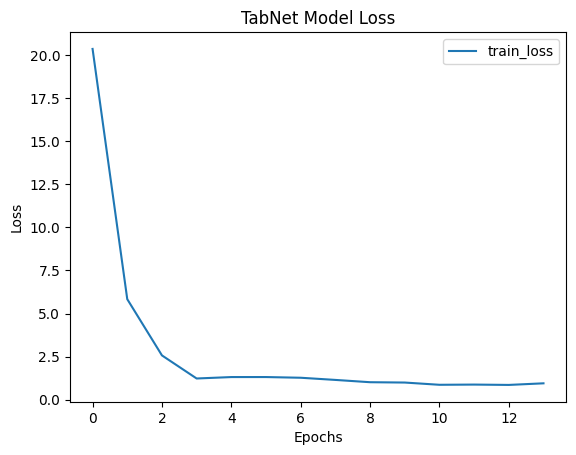

In [28]:
# Plot the history of the model
plt.plot(tabnet.history['loss'], label='train_loss')
plt.xlabel('Epochs')
plt.title('TabNet Model Loss')
plt.ylabel('Loss')
plt.legend()

In [30]:
# Classification report on test data
y_pred = tabnet.predict(X_test.values)

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.86      0.81       111
           1       0.71      0.55      0.62        67

    accuracy                           0.75       178
   macro avg       0.74      0.71      0.72       178
weighted avg       0.74      0.75      0.74       178



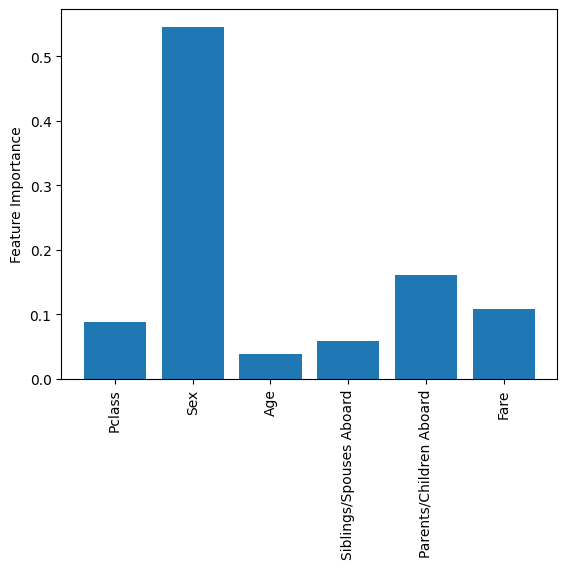

In [31]:
# Plot the feature importance
tabnet.feature_importances_
plt.bar(features, tabnet.feature_importances_)
plt.xticks(rotation=90)
plt.ylabel('Feature Importance')
plt.show()

In [32]:
# Save the model
torch.save(tabnet, 'Model/tabnet_model.pt')

# XGboost with Weighted Class

In [34]:
# Get class weight from y_train
class_weight = y_train.value_counts()
class_weight

Survived
0    434
1    275
Name: count, dtype: int64

In [35]:
# Check y_test distribution
y_test.value_counts()

Survived
0    111
1     67
Name: count, dtype: int64

In [36]:
# Scale pos weight
scale_pos_weight = class_weight[0] / class_weight[1]
print(f"Scale pos weight: {scale_pos_weight}")

Scale pos weight: 1.5781818181818181


In [37]:
# Initialize XGBoost Classifier
xgb_clf = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)

# Train the model
xgb_clf.fit(X_train, y_train)

# Classification report on test data
y_pred = xgb_clf.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       111
           1       0.75      0.75      0.75        67

    accuracy                           0.81       178
   macro avg       0.80      0.80      0.80       178
weighted avg       0.81      0.81      0.81       178



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

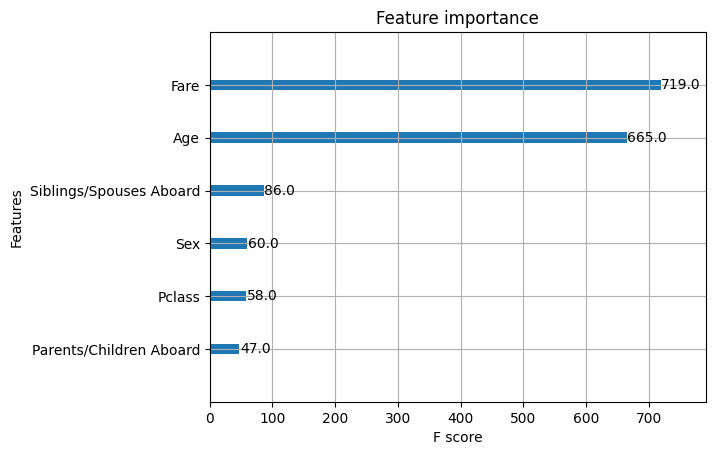

In [39]:
# Feature importance XGBoost
xgb.plot_importance(xgb_clf)

In [38]:
# Save the model
joblib.dump(xgb_clf, 'Model/xgb_model.pkl')

['Model/xgb_model.pkl']